Train: ISOT + ReCOVery + FA-KES

Test: ISOT, ReCOVery, FA-KES (individually)

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4914294846231273575
]


In [3]:
true = pd.read_csv("../brianhelenfakenews/Datasets/ISOT/True.csv", dtype=str)
fake = pd.read_csv ("../brianhelenfakenews/Datasets/ISOT/Fake.csv", dtype=str)
true.head()
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject       date label  \
0  Donald Trump just couldn t wish all Americans ...    News  31-Dec-17     0   
1  House Intelligence Committee Chairman Devin Nu...    News  31-Dec-17     0   
2  On Friday, it was revealed that former Milwauk...    News  30-Dec-17     0   
3  On Christmas day, Donald Trump announced that ...    News  29-Dec-17     0   
4  Pope Francis used his annual Christmas Day mes...    News  25-Dec-17     0   

  Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 162  \
0        NaN        NaN        NaN        NaN        NaN  ...          NaN   
1        NaN        NaN        NaN        NaN        NaN  ...          NaN   
2        NaN        NaN        NaN        NaN        NaN  ...          NaN   
3        NaN        NaN        NaN        NaN        NaN  ...          NaN   
4        NaN        NaN        NaN        NaN        NaN  ...          NaN   

  Unnamed: 163 Unnamed: 164 Unnamed: 165 Unnamed: 166 Unnamed: 167  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

  Unnamed: 168 Unnamed: 169 Unnamed: 170 Unnamed: 171  
0          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN  

[5 rows x 172 columns]

In [4]:
true = true.loc[:, ~true.columns.str.contains('^Unnamed')]
fake = fake.loc[:, ~fake.columns.str.contains('^Unnamed')]
fake = fake.drop(columns=fake.columns[0])
fake = fake.drop(columns=fake.columns[1])
fake = fake.drop(columns=fake.columns[1])
true = true.drop(columns=true.columns[0])
true = true.drop(columns=true.columns[1])
true = true.drop(columns=true.columns[1])

In [5]:
true = shuffle(true, random_state=0)
fake = shuffle(fake, random_state=0)

In [6]:
truetrainpercentage = round(len(true)*0.8)
truetotal = len(true)
faketrainpercentage = round(len(fake)*0.8)
faketotal = len(fake)

In [7]:
truetrain = true[0:truetrainpercentage]
truetest = true[truetrainpercentage:truetotal]
faketrain = fake[0:faketrainpercentage]
faketest = fake[faketrainpercentage:faketotal]

In [8]:
isottestframes = [truetest, faketest]
isottest = pd.concat(isottestframes)
isottest = shuffle(isottest, random_state=0)

In [9]:
truetest

text label
1200   WASHINGTON (Reuters) - The U.S. Federal Commun...     1
13031  BRUSSELS (Reuters) - Turkish Foreign Minister ...     1
11308  HARARE (Reuters) - Retired army chief Constant...     1
1192   GREENBELT, Md. (Reuters) - A U.S. judge on Mon...     1
14613  KABUL (Reuters) - A suicide bomb attack in the...     1
...                                                  ...   ...
13123  CAIRO (Reuters) - Former Egyptian interior min...     1
19648  KHARTOUM (Reuters) - Sudanese President Omar a...     1
9845   RIYADH (Reuters) - U.S. President Barack Obama...     1
10799  WASHINGTON (Reuters) - Former White House nati...     1
2732   WINNIPEG, Manitoba (Reuters) - Former U.S. Pre...     1

[4283 rows x 2 columns]

In [10]:
fa_kes = pd.read_csv("../brianhelenfakenews/Datasets/FA-KESDataset/FA-KES-Dataset.csv")
recovery = pd.read_csv("../brianhelenfakenews/Datasets/ReCOVery/recovery-news-data.csv")

In [11]:
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[2])
fa_kes

text  label
0    Wed 05 Apr 2017 Syria attack symptoms consiste...      0
1    Fri 07 Apr 2017 at 0914 Homs governor says U.S...      0
2    Sun 16 Apr 2017 Death toll from Aleppo bomb at...      0
3    Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...      0
4    Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...      0
..                                                 ...    ...
799  28-08-2016 Turkish Bombardment Kills 20 Civili...      1
800  17-08-2016 Martyrs as Terrorists Shell Aleppos...      1
801  03-08-2016 Chemical Attack Kills Five Syrians ...      0
802  01-08-2016 5 Killed as Russian Military Choppe...      1
803  April 6 2017 Syrian Army Kills 48 ISIL Terrori...      1

[804 rows x 2 columns]

In [12]:
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[1])
recovery = recovery.drop(columns=recovery.columns[1])
recovery

text  label
0     \nA novel respiratory virus that originated in...      1
1     Chinese Health Officials: More Die From Newly ...      1
2     Public health experts around the globe are scr...      1
3     The first two coronavirus cases in Europe have...      0
4     A new coronavirus appeared in Wuhan, China, at...      1
...                                                 ...    ...
2024  © Robert Gauthier/Los Angeles Times/TNS People...      0
2025  Michael Moore, for decades on the political fr...      0
2026  © HEATHER KHALIFA/The Philadelphia Inquirer/TN...      0
2027  Nearly half of the Twitter accounts sharing in...      0
2028  In Brief The Facts: Major events have a lastin...      0

[2029 rows x 2 columns]

In [13]:
fa_kes = shuffle(fa_kes, random_state=0)
recovery = shuffle(recovery, random_state=0)

In [14]:
recoverytrainpercentage = round(len(recovery)*0.8)
recoverytotal = len(recovery)

recoverytrain = recovery[0:recoverytrainpercentage]
recoverytest = recovery[recoverytrainpercentage:recoverytotal]

In [15]:
trainframes = [truetrain, faketrain, recoverytrain]
train = pd.concat(trainframes)
train = shuffle(train, random_state=0)

In [16]:
train.head(5)

text label
19115  A group of lawmakers is planning to request a ...     0
7706   Hillary Clinton has picked up a huge endorseme...     0
840    As Donald Trump continues to target the Democr...     0
10386  One man was set to testify against the Clinton...     0
1928   Michigan Attorney General Dana Nessel is threa...     0

In [17]:
train

text label
19115  A group of lawmakers is planning to request a ...     0
7706   Hillary Clinton has picked up a huge endorseme...     0
840    As Donald Trump continues to target the Democr...     0
10386  One man was set to testify against the Clinton...     0
1928   Michigan Attorney General Dana Nessel is threa...     0
...                                                  ...   ...
8771   Politicians have been known to do a lot of thi...     0
4085   It was just a simple tweet but Stephen King s ...     0
18378  United Airlines should probably consider an ex...     0
8683   If there s one person that you don t want to m...     0
6111   WASHINGTON (Reuters) - U.S. President Donald T...     1

[37559 rows x 2 columns]

In [18]:
import spacy
spacy.load('en_core_web_sm')

In [19]:
#!pip install spacy== 3.0.0
#!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\helen\appdata\local\temp\pip-req-build-bpzw25df
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7692 sha256=d08a1119e3b45ea1c922c06be7856e5e9daa1fa4eb94d6de943221f74ed249eb
  Stored in directory: C:\Users\helen\AppData\Local\Temp\pip-ephem-wheel-cache-9k2zv7oe\wheels\cd\26\af\103cfac199bd773bfc95ed85a52fe9095e4d902ed9ac3b0c97
Successfully built preprocess-kgptalkie


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\helen\AppData\Local\Temp\pip-req-build-bpzw25df'


  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [20]:
import preprocess_kgptalkie as ps

In [21]:
recoverytest

text  label
800   Chongqing Medical University China has found t...      0
281   According to the Korean CDC, COVID-19 may be r...      0
932   Trump has long relied on cronies who flatter h...      1
732   "The Russians are coming!" In April 1945, the ...      0
715   The city on Friday outlined the rules for each...      1
...                                                 ...    ...
835   You don’t know what you’ve got till it’s gone....      0
1216  The German response to the coronavirus has led...      1
1653  Recruited by a member of a Palestinian terrori...      0
559   Chicagoans who have a burning curiosity to kno...      1
684   For the first time in its nearly 20-year histo...      1

[406 rows x 2 columns]

In [22]:
train['text'] = train['text'].apply(lambda x: str(x).lower())
isottest['text'] = isottest['text'].apply(lambda x: str(x).lower())
fa_kes['text'] = fa_kes['text'].apply(lambda x: str(x).lower())
recoverytest['text'] = recoverytest['text'].apply(lambda x: str(x).lower())

train['text'] = train['text'].apply(lambda x: ps.remove_special_chars(x))
isottest['text'] = isottest['text'].apply(lambda x: ps.remove_special_chars(x))
fa_kes['text'] = fa_kes['text'].apply(lambda x: ps.remove_special_chars(x))
recoverytest['text'] = recoverytest['text'].apply(lambda x: ps.remove_special_chars(x))

C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [23]:
fa_kes

text  label
8    sun 01 feb 2015 explosion rocks down town dama...      1
575  thu feb 26 2015 isis begins to kill abducted c...      0
616  wed mar 2 2016 18 militants killed in car bomb...      1
142  usbacked syrian fighters pressing is gunmen in...      1
236  syria rebels kill 7 in aleppo assault capture ...      1
..                                                 ...    ...
763  29062016 7 civilians killed 25 injured in terr...      0
192  suicide bomber kills six in syria restaurant r...      1
629  sat nov 12 2016 2 killed 10 injured in terrori...      1
559  wednesday 16 november 2016 syrian russian jets...      1
684  28052017updated 1549 28052017 get short url 63...      1

[804 rows x 2 columns]

In [24]:
trainx = [d.split() for d in train['text'].tolist()]
trainy = train['label'].values

isotx = [d.split() for d in isottest['text'].tolist()]
isoty = isottest['label'].values

fa_kesx = [d.split() for d in fa_kes['text'].tolist()]
fa_kesy = fa_kes['label'].values

recoverytestx = [d.split() for d in recoverytest['text'].tolist()]
recoverytesty = recoverytest['label'].values

In [25]:
isoty

array(['1', '1', '1', ..., '0', '1', '1'], dtype=object)

In [26]:
DIM = 400
trainw2v_model = gensim.models.Word2Vec(sentences=trainx, vector_size=DIM, window=10, min_count=1)

isotw2v_model = gensim.models.Word2Vec(sentences=isotx, vector_size=DIM, window=10, min_count=1)

fa_kesw2v_model = gensim.models.Word2Vec(sentences=fa_kesx, vector_size=DIM, window=10, min_count=1)

recoveryw2v_model = gensim.models.Word2Vec(sentences=recoverytestx, vector_size=DIM, window=10, min_count=1)

# size --> vector_size

In [27]:
print(len(trainw2v_model.wv.key_to_index))

print(len(isotw2v_model.wv.key_to_index))

print(len(fa_kesw2v_model.wv.key_to_index))

print(len(recoveryw2v_model.wv.key_to_index))

242523
94160
11007
28115


In [28]:
traintokenizer = tf.keras.preprocessing.text.Tokenizer()
traintokenizer.fit_on_texts(trainx)

isottokenizer = tf.keras.preprocessing.text.Tokenizer()
isottokenizer.fit_on_texts(isotx)

fa_kestokenizer = tf.keras.preprocessing.text.Tokenizer()
fa_kestokenizer.fit_on_texts(fa_kesx)

recoverytokenizer = tf.keras.preprocessing.text.Tokenizer()
recoverytokenizer.fit_on_texts(recoverytestx)

In [29]:
trainx = traintokenizer.texts_to_sequences(trainx)

isotx = isottokenizer.texts_to_sequences(isotx)

fa_kesx = fa_kestokenizer.texts_to_sequences(fa_kesx)

recoverytestx = recoverytokenizer.texts_to_sequences(recoverytestx)

train


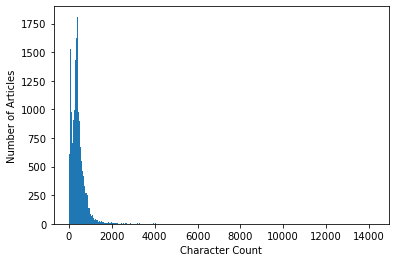

In [30]:
plt.hist([len(a) for a in trainx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("train")
plt.show()

isot


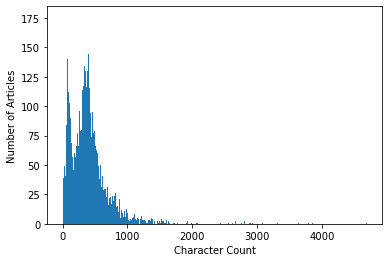

In [31]:
plt.hist([len(a) for a in isotx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("isot")
plt.show()

fa_kes


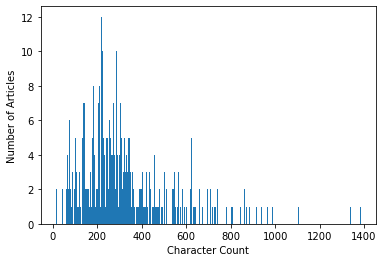

In [32]:
plt.hist([len(a) for a in fa_kesx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("fa_kes")
plt.show()

recovery


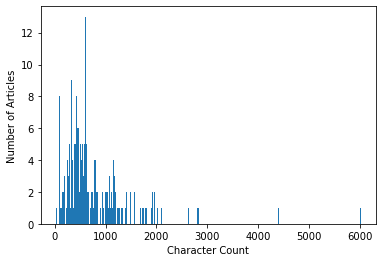

In [33]:
plt.hist([len(a) for a in recoverytestx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("recovery")
plt.show()

In [34]:
trainnos = np.array([len(a) for a in trainx])
len(trainnos[trainnos>1000])

isotnos = np.array([len(a) for a in isotx])
len(isotnos[isotnos>1000])

fa_kesnos = np.array([len(a) for a in fa_kesx])
len(fa_kesnos[fa_kesnos>1000])

recoverynos = np.array([len(a) for a in recoverytestx])
len(recoverynos[recoverynos>1000])

100

In [35]:
recoverytestx

[[11856,
  114,
  284,
  231,
  18,
  277,
  7,
  370,
  360,
  35,
  11857,
  20,
  44,
  28,
  864,
  774,
  2,
  16,
  4450,
  3,
  1,
  108,
  41,
  277,
  2,
  13,
  52,
  1,
  698,
  1285,
  375,
  191,
  11858,
  2,
  1,
  282,
  516,
  370,
  360,
  35,
  1106,
  238,
  12,
  21,
  65,
  4,
  1144,
  10,
  2,
  2406,
  28,
  864,
  774,
  2,
  16,
  4450,
  3,
  1,
  6824,
  108,
  980,
  275,
  2407,
  3,
  698,
  1285,
  7,
  482,
  21,
  11859,
  826,
  105,
  9,
  106,
  6825,
  62,
  6,
  34,
  1570,
  2,
  164,
  35,
  18,
  163,
  52,
  1,
  65,
  4,
  19,
  189,
  2,
  864,
  61,
  396,
  1571,
  3,
  1286,
  629,
  119,
  11860,
  20,
  44,
  397,
  75,
  505,
  452,
  165,
  95,
  774,
  123,
  14,
  239,
  360,
  28,
  864,
  90,
  63,
  1075,
  9,
  728,
  2,
  5754,
  629,
  4,
  81,
  77,
  273,
  1,
  629,
  53,
  107,
  28,
  11861,
  385,
  19,
  1174,
  2,
  117,
  1107,
  54,
  3,
  72,
  600,
  4,
  16,
  4036,
  8562,
  8563,
  585,
  12,
  5027,
  11862,
 

In [36]:
maxlen = 100
trainx = tf.keras.preprocessing.sequence.pad_sequences(trainx, maxlen=maxlen)

isotx = tf.keras.preprocessing.sequence.pad_sequences(isotx, maxlen=maxlen)

fa_kesx = tf.keras.preprocessing.sequence.pad_sequences(fa_kesx, maxlen=maxlen)

recoverytestx = tf.keras.preprocessing.sequence.pad_sequences(recoverytestx, maxlen=maxlen)

In [37]:
trainvocab_size = len(traintokenizer.word_index) + 1
trainvocab = traintokenizer.word_index

isotvocab_size = len(isottokenizer.word_index) + 1
isotvocab = isottokenizer.word_index

fa_kesvocab_size = len(fa_kestokenizer.word_index) + 1
fa_kesvocab = fa_kestokenizer.word_index

recoveryvocab_size = len(recoverytokenizer.word_index) + 1
recoveryvocab = recoverytokenizer.word_index

In [38]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((trainvocab_size, DIM))
    
    for word, i in trainvocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [39]:
embedding_vectors = get_weight_matrix(trainw2v_model)

In [40]:
embedding_vectors.shape

(242524, 400)

In [53]:
model = Sequential()

model.add(Embedding(trainvocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(256, 5, activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid")) 
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 400)          97009600  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 256)           512256    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 97,558,881
Trainable params: 549,281
Non-trainable params: 97,009,600
_________________________________________________________________


In [54]:
len(trainx)

37559

In [55]:
trainx = np.asarray(trainx).astype(np.float32)
trainy = np.asarray(trainy).astype(np.float32)

isotx = np.asarray(isotx).astype(np.float32)
isoty = np.asarray(isoty).astype(np.float32)

fa_kesx = np.asarray(fa_kesx).astype(np.float32)
fa_kesy = np.asarray(fa_kesy).astype(np.float32)

recoverytestx = np.asarray(recoverytestx).astype(np.float32)
recoverytesty = np.asarray(recoverytesty).astype(np.float32)

In [56]:
trainx

array([[3.81000e+02, 7.33930e+04, 1.97900e+03, ..., 3.05000e+02,
        1.20800e+03, 1.00000e+02],
       [2.70000e+01, 1.00000e+00, 1.34230e+04, ..., 2.83000e+04,
        2.04000e+02, 6.99400e+03],
       [1.50000e+01, 6.15000e+03, 1.15687e+05, ..., 2.71000e+02,
        6.90000e+02, 9.03800e+03],
       ...,
       [1.27930e+04, 4.00000e+00, 1.71500e+03, ..., 6.81520e+04,
        3.60000e+02, 1.00000e+02],
       [3.72000e+02, 9.51000e+02, 6.00000e+01, ..., 2.42523e+05,
        2.04000e+02, 2.77000e+02],
       [6.81000e+02, 1.03100e+03, 3.00000e+00, ..., 2.00000e+00,
        1.68400e+03, 5.30000e+01]], dtype=float32)

In [57]:
model.fit(trainx, trainy, epochs=5, batch_size=64)

Epoch 1/5
587/587 [==============================] - 60s 95ms/step - loss: 0.1309 - accuracy: 0.9520 - recall: 0.9593 - precision: 0.9427 - true_negatives: 18273.0000 - true_positives: 17482.0000 - false_positives: 1062.0000 - false_negatives: 742.0000
Epoch 2/5
587/587 [==============================] - 56s 96ms/step - loss: 0.0782 - accuracy: 0.9714 - recall: 0.9753 - precision: 0.9660 - true_negatives: 18709.0000 - true_positives: 17774.0000 - false_positives: 626.0000 - false_negatives: 450.00004s - loss: 0.0780 - accuracy: 0.9720 - recall: 0.9772 - precision: 0.9665 - true_negatives: 6712.0000 - true_positives: 6601.0000 - f - ETA: 32s - loss: 0.0775 - accu - ETA: 15s - loss: 0.0783 - accuracy: 0.9716 - recall: 0.9754 - precision: 0.9666 - true_ne - ETA: 10s - loss: 0.0788 - accuracy: 0.9711 - recall: 0.9750 - precision: 0.9657 - true_negatives: 1 - ETA: 2s - loss: 0.0781 - accuracy: 0.9714 - recall: 0.9754 - precision: 0.9659 - true_negatives: 17992.0000 - true_positives: 17072.0

In [ ]:
model.evaluate(isotx, isoty)

228/281 [=======================>......] - ETA: 1s - loss: 0.9541 - accuracy: 0.7133 - recall: 0.7687 - precision: 0.6770 - true_negatives: 2515.0000 - true_positives: 2689.0000 - false_positives: 1283.0000 - false_negatives: 809.0000